# Feature Extraction / Feature Engineering

Until now, we just used the following columns: `["Pclass", "Age", "SibSp", "Parch", "Fare"]`. 
However, there are way more columns. Unluckily, they are strings and cannot be used natively by most machine learning algorithms. Let's see what we can do about that:


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('train.csv')
df = df.fillna(0)

## Feature Extraction

As you can see, we have 5 columns that have the type string: `["Name", "Sex", "Ticket", "Cabin", "Embarked"]`.

Lets start with the `Sex` property, as it is the easiest. To use this in a classifier we can simply encode it using a binary rule: `male` -> 0, `female` -> 1. 

For that, we first have to select the elements we want to change, which can be done using `df.loc[rows, cols]`. The first parameter specifies the columns which will be selected and the second one the rows. This can be done with a boolean expression and the name of a column, e.g. `df.loc[df["Sex"] == "male", "Sex"] = 0` selects all rows, where `Sex` is `male` and then sets the corresponding values to `0`.   

Let's see how much that improves our model:

In [5]:
df.loc[df["Sex"] == "male", "Sex"] = 0
df.loc[df["Sex"] == "female", "Sex"] = 1

In [6]:
from sklearn.model_selection import train_test_split

features = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex"]

xTrain, xTest, yTrain, yTest = train_test_split(
    df[features],
    df["Survived"],
    stratify = df["Survived"],
    random_state = 42
)

In [7]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(xTrain, yTrain)
tree.score(xTrain, yTrain)

0.9820359281437125

In [8]:
tree.score(xTest, yTest)

0.7713004484304933

We got way better, just by adding this one feature!
Seems like it mattered a lot, if you were male or female. 

Let's see if we can apply this to other features, e.g. `"Embarked"`.

It can have four values C = Cherbourg, Q = Queenstown, S = Southampton, for the three ports, where people boarded the Titanic or nothing, if it is uncertain where the person boarded the ship. 
There are two ways to encode the values. Either as a mapping, C -> 0, Q -> 1, S -> 2 or as three binary features, isC, isQ, isS. The mapping approach saves two feature inputs, but implies a certain ranking for the three ports (This might be valid, if one town has richer occupants than the others). For the missing port we could add another mapping (binary columns) or we could assign it the most occuring port.

Let us go with binary columns for the time being and add one for the port missing as well. pandas has a super convenient function for this `pd.get_dummies`

In [9]:
df = df.join(pd.get_dummies(df["Embarked"], prefix="is"))
df = df.drop("Embarked", axis=1)

In [10]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,is_0,is_C,is_Q,is_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,0.0,1,2,W./C. 6607,23.4500,0,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,0,1,0,0


In [11]:
from sklearn.model_selection import train_test_split

features = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "is_0", "is_C", "is_Q", "is_S"]

xTrain, xTest, yTrain, yTest = train_test_split(
    df[features],
    df["Survived"],
    stratify = df["Survived"],
    random_state = 42
)

In [12]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(xTrain, yTrain)
tree.score(xTrain, yTrain)

0.9820359281437125

In [13]:
tree.score(xTest, yTest)

0.7533632286995515

## Feature Engineering

#### Build additional features:
Data may contain information that is hard, or even impossible to grasp for a machine learning algorithm, for example the importance of a certain title, public holidays which occur on different dates, sudden changes in human decision making (e.g. the transition from child to young adult)... This information has to be provided explicitly to the algorithm as an extra feature, as it does not have common knowledge. This important Data Science process is called "Feature Engineering", and often makes the difference between a good and a bad model.

#### In our case, the following extra features could be added:
- The title of each person might correlate with their survival probabillity. (e.g. Mr. most unlikely, Miss more likely, Countess most likely,...)
- The size of a family might matter as these people are likely to help each other. This is however currently split up between two columns `SibSp` and `Parch`, we could merge them to a `FamilySize` column by adding them to each other.
- In earlier times, wealthier people often had longer names, so this could be another feature.
- The change from being a child to being an adult, as people are more likely to give the spot in a rescue boat to a child (combination of `Title`, `Age`, and `Sex`)
- The number of relatives on the boat, as those are people which are likely to help each other.
- An `ID` for each family on the boat. If one member survives, the are more likely to be in the same rescue boat.
- If `NaN` values are replaced, we can add the feature col Missing
- etc.

Let us starting the process of feature engineering by calculating a family size.

In [21]:
df["FamilySize"] = df["Parch"] + df["SibSp"]

This was easy right? Let's continue with feature engineering on the `Name` column. For that let us look at some examples from that column: 

In [14]:
print(df["Name"].iloc[888])
print(df["Name"].iloc[1])

Johnston, Miss. Catherine Helen "Carrie"
Cumings, Mrs. John Bradley (Florence Briggs Thayer)


The `Name` property is a bit more complex. Besides normal names, it contains rows with names in brackets and with double quotes.

In case of double quotes, a nickname is provided, e.g. `Johnston, Miss. Catherine Helen "Carrie"`. This could be saved in a binary property as having a nickname or not. Afterwards, the brackets and their contents can be removed.

In case of no double quotes, an old-fashioned way of referring to women is used, e.g. `Cumings, Mrs. John Bradley (Florence Briggs Thayer)` refers to the wife of `Mr. John Bradley Cumings` with the maiden name `Florence Briggs Thayer`. This can help for filling missing ages, if one assumes that married couples have similar ages (can be tested with the data). Similarly, the titles `Master` (title of male children) and `Miss` (unmarried women) should be younger than the average.

Additionally, we can figure out which people belong to a family by setting a family id made up from the family name and the number of siblings, spouses, parents and children that or on board. As relatives normally stick together closely, it might be reasonable that certain family ids have a higher probability of survival than others.

Let us start by extracting the title and assigning value to it which might correlate with their survival probabillity. (e.g. Mr. most unlikely, Miss more likely, Countess most likely,...)

In [15]:
# Here are some helper functions
import re

titleMapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, 
                "Dr": 5, "Rev": 6, "Major": 7,
                "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, 
                "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, 
                "Capt": 7, "Ms": 2}

def get_title(name):
    # Use a regular expression to search for a title.  
    # Titles always consist of capital and lowercase letters, and end with a period.
    titleSearch = re.search('([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if titleSearch:
        for k,v in titleMapping.items():
            if k==titleSearch.group(1) : return v
    return 0

def test_get_title(name_with_title: str, title_value: str):
    assert get_title(name_with_title) == title_value
    
name_title_map = {
    "Braund, Mr. Owen Harris": 1,
    "Johnston, Miss. Catherine Helen \"Carrie\"": 2,
    "Cumings, Mrs. John Bradley (Florence Briggs Thayer)": 3
}
for k, v in name_title_map.items():
    test_get_title(k, v)

Let us continuing by assigining a familyId to people. This should be the same id if the family is the same and the sum of `FamilySize` is equal.

In [22]:
from typing import Dict
import operator

def get_family_id(row: pd.Series, family_id_map: Dict[str, int]) -> int:
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_map:
        if len(family_id_map) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_map.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_map[family_id] = current_id
    return family_id_map[family_id]

def test_get_family_id():
    family_id_map = {
        "Cummings5": 1,
        "Cummings3": 2
    }
    test_df = pd.DataFrame(
        columns=["Name", "FamilySize"], 
        data = [
            ("Cummings", 5),
            ("Cummings", 4),
            ("Cummings", 3),
            ("Johnston", 5),
        ])
    expected_results = [1, 3, 2, 4]
    assert [get_family_id(row, family_id_map) for _, row in test_df.iterrows()] == expected_results

test_get_family_id()

To apply the same transformations on training and test data we should pack all of the preporcessing into a function which we can simply pass a dataframe to and it does all these transformations for us:

In [31]:
def preprocessDf(frame, family_id_map):
    # Start by encoding the Sex as a number
    # Replace all the occurences of male with the number 0.
    frame.loc[frame["Sex"] == "male", "Sex"] = 0
    # Replace all the occurences of female with the number 1.
    frame.loc[frame["Sex"] == "female", "Sex"] = 1
    
    frame = frame.join(pd.get_dummies(frame["Embarked"], prefix="is"))
    frame = frame.drop("Embarked", axis=1)
    
    frame["AgeMissing"] = pd.isnull(frame["Age"]).astype(int)
    frame["Age"] = frame["Age"].fillna(frame["Age"].median())
    
    frame["FamilySize"] = frame["SibSp"] + frame["Parch"]
        
    frame["Title"] = frame["Name"].apply(get_title)
        
    frame["FamilyId"] = frame.apply(get_family_id, args=(family_id_map,), axis=1)
    
    return frame, family_id_map

df = pd.read_csv('train.csv')
family_id_map = {}
df, family_id_map = preprocessDf(df, family_id_map)
# The properties Name, Ticket and Cabin are not needed any longer
df.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True, errors = 'ignore')

In [32]:
df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_C,is_Q,is_S,AgeMissing,FamilySize,Title,FamilyId
0,1,0,3,0,22.0,1,0,7.2500,0,0,1,0,1,1,1
1,2,1,1,1,38.0,1,0,71.2833,1,0,0,0,1,3,2
2,3,1,3,1,26.0,0,0,7.9250,0,0,1,0,0,2,3
3,4,1,1,1,35.0,1,0,53.1000,0,0,1,0,1,3,4
4,5,0,3,0,35.0,0,0,8.0500,0,0,1,0,0,1,5


## Visualization
Now that we have our feature set, let us actually investigate the data similar to the investigation in the [numerical exploration](./02-ExplorationNumeric.ipynb). 


With this knowledge about the feature importance,
we can either revisit the step of the data preprocessing or start developing a machine learning algorithm (also called a "classifier").

## Let us train our model again

There is a huge variety of models which can be selected, e.g. Linear Regression, Logistic Regression, Decision Trees, Random Forests, Gradient Boost Trees, and Neural Networks. Most of these classifiers are implemented in the `sklearn` package. 

Let's try a Logistic Regression, a Decision Tree, a Random Forest, and a Gradient Boost Tree, and then have a look how they compare. 

Let us apply the knowledge of [splitting datasets](./04-TrainTestSplit.ipynb) to first get a training and test set.


In [ ]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(
    df[features],
    df["Survived"],
    stratify = df["Survived"],
    random_state = 42
)


Now let us [train an algortihm](./03-SklearnIntroduction.ipynb).

In [36]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
clf = DecisionTreeClassifier()
clf.fit(xTrain, yTrain)
print(clf.score(xTrain, yTrain))
print(clf.score(xTest, yTest))

0.9820359281437125
0.7533632286995515


Note that this gives us only a starting point about which direction to go, because we just ran all the classifiers with a subset of their parameters. Most classifiers are very sensitive to changes of those parameters. Therefore, it is good practice to read the documentation and statistical background before using new classifiers and interpreting their results.

To test how the models handle different parameter sets, we can use `GridSearch`. This evaluates the model with multiple sets of parameters. However, this can lead to excessive computation time (good hardware and parallel computing help though).

In [47]:
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeClassifier(random_state=42)
paramGrid = {'max_depth': [1,2,3,8,None],
            'max_features': [1,2,4,8,None]}
grid = GridSearchCV(clf, param_grid=paramGrid, cv=5)
grid.fit(xTrain, yTrain)
print(grid.score(xTest, yTest))

0.8071748878923767


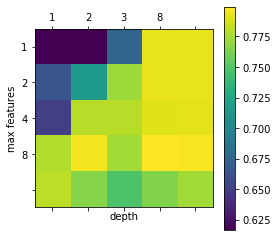

In [48]:
import json

import numpy as np
from matplotlib import pyplot as plt

plt.matshow(np.array(grid.cv_results_["mean_test_score"]).reshape(5, -1))
plt.xlabel("depth")
plt.ylabel("max features")
plt.xticks(range(len(paramGrid['max_depth'])), paramGrid['max_depth'])
plt.yticks(range(len(paramGrid['max_features'])), paramGrid['max_features'])
plt.colorbar()

Now it is your time to change the code above to figure out how good you can get.